In [1]:
#%matplotlib ipympl

#from ipywidgets import *

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy

In [2]:
data = pd.read_csv("../data_2/data.csv")
data

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2),Absolute acceleration (m/s^2)
0,0.006901,-1.1901,-0.3100,-2.0644,2.402953
1,0.016901,-1.1901,-0.3100,-2.0644,2.402953
2,0.026901,-1.1901,-0.3100,-2.0644,2.402953
3,0.036904,-0.1222,0.1782,0.2060,0.298537
4,0.046901,0.5451,-0.1988,0.5428,0.794536
...,...,...,...,...,...
43625,436.256901,-0.3726,0.5885,0.1457,0.711612
43626,436.266901,-0.7199,0.1504,1.1852,1.394839
43627,436.276901,-0.9928,-0.2227,1.6173,1.910734
43628,436.286901,-1.4519,-0.2955,1.2412,1.932851


In [3]:
x = data["Linear Acceleration x (m/s^2)"]
y = data["Linear Acceleration y (m/s^2)"]
z = data["Linear Acceleration z (m/s^2)"]
absolute = data["Absolute acceleration (m/s^2)"]

time = data["Time (s)"]


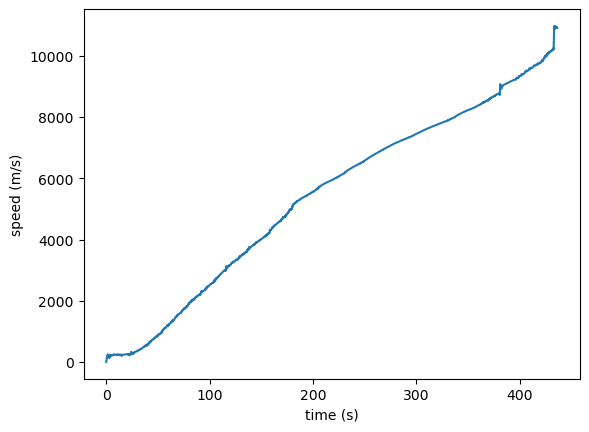

In [4]:
x_speed, y_speed, z_speed = (scipy.integrate.cumulative_trapezoid(frame) for frame in (x, y, z))
speed = np.sqrt(x_speed**2 + y_speed**2 + z_speed**2)

plt.close(1)
fig = plt.figure(1)
ax = fig.add_subplot()

ax.plot(time[:-1], speed)
ax.set_xlabel("time (s)")
ax.set_ylabel("speed (m/s)")
fig.savefig('fig1.svg')

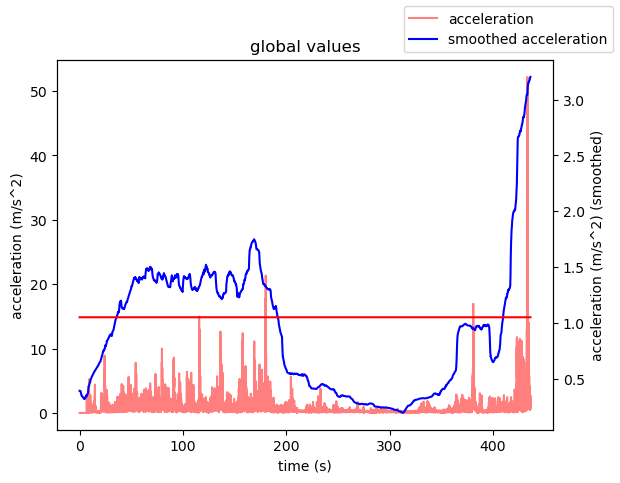

In [5]:
plt.close(2)
fig2 = plt.figure(2)


def update(n_glob=3200, thresh=1.05, remove_start=700):
    fig2.clear()

    ax2 = fig2.add_subplot()
    ax2.set_title('global values')
    ax3 = ax2.twinx()

    ax2.set_xlabel("time (s)")
    ax2.set_ylabel("acceleration (m/s^2)")
    ax3.set_ylabel("acceleration (m/s^2) (smoothed)")

    absolute_cp = np.copy(absolute)
    absolute_cp[:remove_start] = 0
    absolute_smooth = scipy.ndimage.uniform_filter1d(absolute_cp, size=n_glob)

    _ = ax2.plot(time, absolute, alpha=0.5, color='red', label="acceleration")
    _ = ax3.plot(time, absolute_smooth, color='blue', label="smoothed acceleration")

    _ = ax3.plot(time, [thresh]*len(time), color='red', label="")
    
    fig2.legend()
    fig2.canvas.draw_idle()
    fig2.savefig('fig3.svg')


update()

#interact(update, n_glob=(100, 5000, 100), thresh=(0, 2, .05), remove_start=(0, len(time)-1, 100));

In [6]:
tps_grimpe = 193.5 - 33.9
tps_chute = 437.3 - 410.2 # Incohérent
tps_grimpe, tps_chute

(159.6, 27.100000000000023)

In [7]:
n_glob = 3200
thresh = 1.05
remove_start = 700

41.88 %


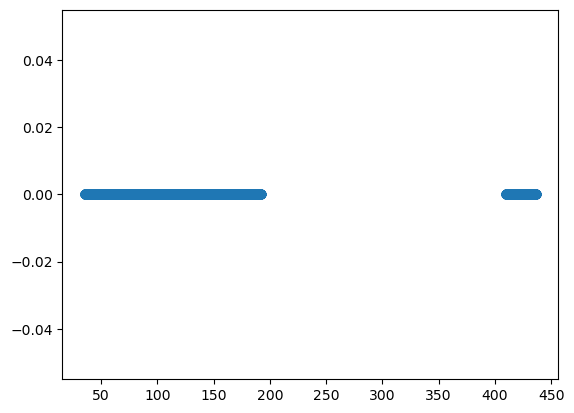

In [8]:
absolute_smooth = scipy.ndimage.uniform_filter1d(absolute, size=n_glob)

moving_time = time[absolute_smooth > thresh]
moving_ones = np.zeros(len(moving_time))

moving_ratio = len(moving_time) / len(time) 
print(f"{np.round(moving_ratio*100, 2)} %")

plt.close(3)
fig3 = plt.figure(3)

ax = fig3.add_subplot()

fig3.savefig("fig_time.svg")

_ = ax.scatter(moving_time, moving_ones)

NameError: name 'interact' is not defined

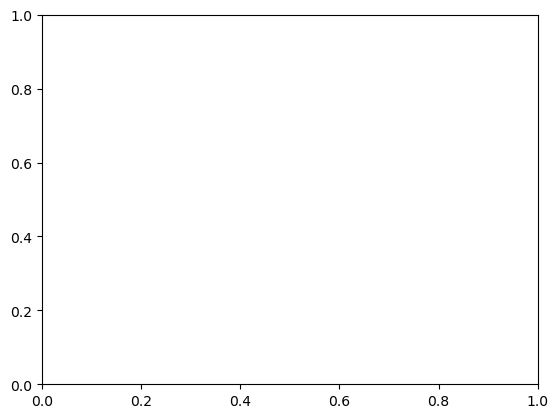

In [9]:
import pywt

def wavelet_denoise(data, wavelet):
    '''Filter accelerometer data using wavelet denoising

    Modification of F. Blanco-Silva's code at: https://goo.gl/gOQwy5
    '''
    import numpy
    import scipy
    import pywt

    noise_sigma = np.std(data)

    wavelet = pywt.Wavelet(wavelet)
    levels  = min(1, (numpy.floor(numpy.log2(data.shape[0]))).astype(int))

    # Francisco's code used wavedec2 for image data
    wavelet_coeffs = pywt.wavedec(data, wavelet, level=levels)
    threshold = noise_sigma*numpy.sqrt(2*numpy.log2(data.size))

    new_wavelet_coeffs = map(lambda x: pywt.threshold(x, threshold, mode='soft'),
                             wavelet_coeffs)

    return pywt.waverec(list(new_wavelet_coeffs), wavelet)

def wavelets(data, wavelet, uselevels, mode):
    levels = (np.floor(np.log2(data.shape[0]))).astype(int)
    omit = levels - uselevels
    coeffs = pywt.wavedec(data, wavelet, level=levels)
    A = pywt.waverec(coeffs[:-omit] + [None] * omit, wavelet, mode=mode)
    return A

def rolling_mean(data, n=100):
    factor = np.concatenate((np.ones(n+1, dtype=int), np.zeros(n, dtype=int)))
    return np.convolve(data, factor, mode='same')

# cA, cD = pywt.dwt(glob, 'db2')

plt.close(4)
fig = plt.figure(4)
ax = fig.add_subplot()

def update(n=10):
    try:
        x_den, y_den, z_den = (
            wavelets(data, 'db2', n, 'zero')
            for data in (x, y, z)
        )
    except ValueError:
        return
    
    glob_den = np.sqrt(x_den**2+y_den**2+z_den**2)

    ax.cla()
    ax.plot(x_den, alpha=.5, label='x_den')
    ax.plot(y_den, alpha=.5, label='y_den')
    ax.plot(z_den, alpha=.5, label='z_den')
    ax.plot(glob_den, alpha=.5, label='glob_den')
    fig.legend()
    fig.canvas.draw_idle()

interact(update, n=(1, 40, 1));